<a href="https://colab.research.google.com/github/Alro10/deep-learning-time-series/blob/master/LSTM_sine_wave_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM sine wave prediction

References:

- https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f

In [1]:
# Import packages
import pandas as pd
import numpy as np
%tensorflow_version 1.x
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
# Take dataset from repository
!wget https://raw.githubusercontent.com/kmsravindra/ML-AI-experiments/master/AI/LSTM-time_series/sine-wave.csv

--2019-11-29 14:03:59--  https://raw.githubusercontent.com/kmsravindra/ML-AI-experiments/master/AI/LSTM-time_series/sine-wave.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66713 (65K) [text/plain]
Saving to: ‘sine-wave.csv.1’

sine-wave.csv.1     100%[===================>]  65.15K  --.-KB/s    in 0.01s   

2019-11-29 14:03:59 (4.39 MB/s) - ‘sine-wave.csv.1’ saved [66713/66713]



In [3]:
# Load dataset as pandas dataframe
df = pd.read_csv('sine-wave.csv', header=None )
print(df.head())
print(df.shape)

          0
0  0.841471
1  0.873736
2  0.902554
3  0.927809
4  0.949402
(5001, 1)


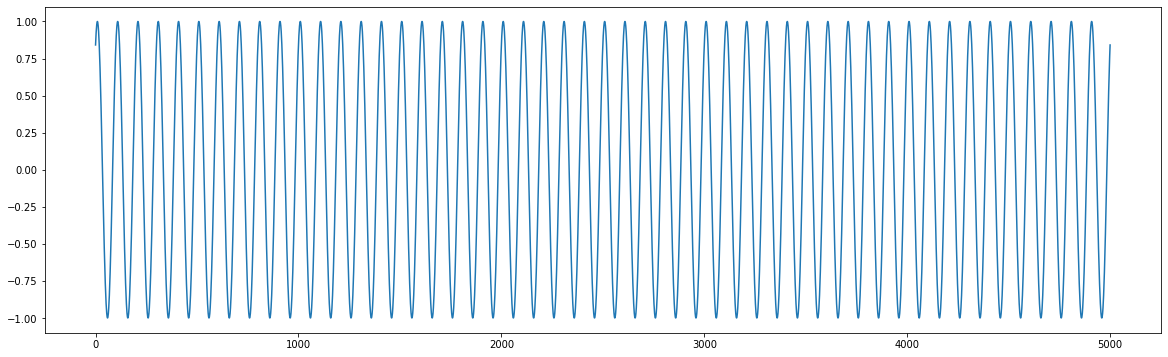

In [4]:
plt.figure(figsize=(20,6))
plt.plot(df.values)
plt.show()

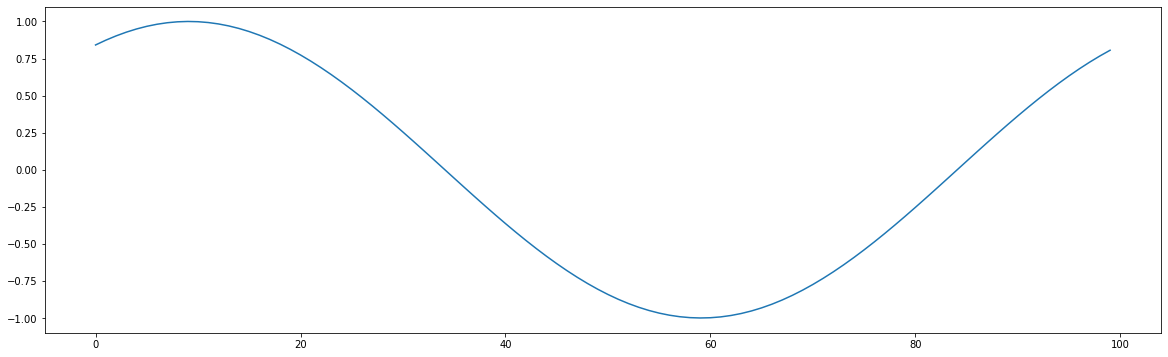

In [5]:
# Plot first 1000 values
plt.figure(figsize=(20,6))
plt.plot(df.values[:100])
plt.show()

In [6]:
# Normalize features 
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df.values)
series = pd.DataFrame(scaled)
print(series.head())
print(series.shape)

          0
0  0.841483
1  0.873749
2  0.902566
3  0.927822
4  0.949416
(5001, 1)


In [7]:
# Setup the time steps
window_size = 50

series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)
print(series.head())
print(series.shape)

          0         0         0  ...         0         0         0
0  0.841483  0.873749  0.902566  ... -0.767129 -0.805896 -0.841483
1  0.873749  0.902566  0.927822  ... -0.805896 -0.841483 -0.873749
2  0.902566  0.927822  0.949416  ... -0.841483 -0.873749 -0.902566
3  0.927822  0.949416  0.967263  ... -0.873749 -0.902566 -0.927822
4  0.949416  0.967263  0.981292  ... -0.902566 -0.927822 -0.949416

[5 rows x 51 columns]
(4951, 51)


In [8]:
# Split data into training (80%) and test (20%)
nrow = round(0.8*series.shape[0])
train = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]
print(train.shape)
print(test.shape)

from sklearn.utils import shuffle
train = shuffle(train)
# Discard the last value
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

train_X = train_X.values
print(train_X.shape)
train_y = train_y.values
print(train_y.shape)
test_X = test_X.values
print(test_X.shape)
test_y = test_y.values
print(test_y.shape)

(3961, 51)
(990, 51)
(3961, 50)
(3961,)
(990, 50)
(990,)


**Note**: Preparing the 3D input vector for the LSTM. Remember, the input vector for LSTM is 3D array: (num_samples, num_time_steps, num_features). In this case we have num of time steps = 50 and num_features = 1

In [9]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
print(train_X.shape)
print(test_X.shape)

(3961, 50, 1)
(990, 50, 1)


In [10]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (50,1), output_dim= 50, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Tot

In [16]:
t1 = datetime.datetime.now()
history = model.fit(train_X, train_y, batch_size=512, epochs=5, validation_split=0.1)
t2 = datetime.datetime.now()
print("Compilation Time : ", t2-t1)

Train on 3564 samples, validate on 397 samples
Epoch 1/5
3564/3564 [==============================] - 1s 313us/step - loss: 0.0119 - val_loss: 2.7717e-04
Epoch 2/5
3564/3564 [==============================] - 1s 305us/step - loss: 0.0104 - val_loss: 5.0883e-04
Epoch 3/5
3564/3564 [==============================] - 1s 308us/step - loss: 0.0095 - val_loss: 8.3049e-04
Epoch 4/5
3564/3564 [==============================] - 1s 300us/step - loss: 0.0086 - val_loss: 4.8961e-04
Epoch 5/5
3564/3564 [==============================] - 1s 329us/step - loss: 0.0076 - val_loss: 3.9359e-04
Compilation Time :  0:00:05.552616


In [17]:
# Doing a prediction on all the test data at once
preds = model.predict(test_X)
preds = scaler.inverse_transform(preds)
print(preds.shape)

(990, 1)


In [0]:
#test_y = test_y.reshape(-1, 1)
#print(test_y.shape)
actuals = scaler.inverse_transform(test_y)

In [19]:
rmse_error = mean_squared_error(actuals, preds)
print(rmse_error)

0.0003958811954194622


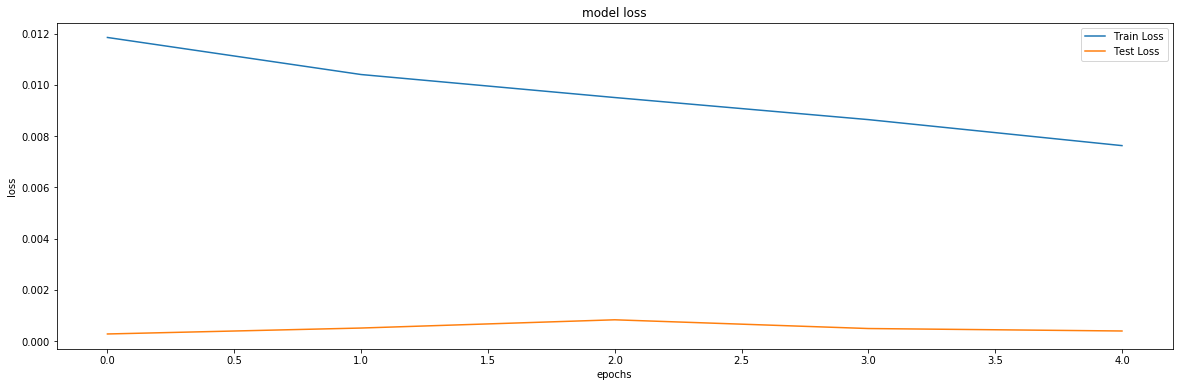

In [20]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()